In [1]:
import datetime as dt
import os
import netCDF4 as nc
import matplotlib as mpl
import time

import numpy as np
import numpy.ma as ma
from scipy.spatial import distance
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.colors as mpl_colors
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D




from salishsea_tools import geo_tools, viz_tools
% matplotlib inline

#### 1. First, load and select the desired trajectories. 
I have put the selected rows (nday=50) into an array called points which has the same 5 columns as the original traj.txt file

In [2]:
# direct = "/ocean/gsgarbi/analysis-giorgio/time_series/results2/20160601_20160630_264d/"
# traj=np.loadtxt(direct+"/traj.txt", delimiter = ' ')

# nday=50
# tunit=3600
# ntfic=1
# lmt=1896
# # time as fraction of 1 tcyc:
# ndaytcyc=nday*24*3600/(tunit*ntfic*lmt)

# # find the location of the nearest time in the trajectories to the desired time
# flocs=np.argmin(np.abs(traj[:,4]-ndaytcyc))
# # get the actual time in the traj file
# nearestT=traj[flocs,4]
# # return only the points matching the desired time
# crit=traj[:,4]==nearestT


In [3]:
# T1 = dt.datetime.now()

# path = "/ocean/gsgarbi/analysis-giorgio/time_series/results2/2016/"

# dirs = os.listdir( path )

# dirs = sorted(dirs)

# points = [[0,0,0,0,0]]

# nday=50
# tunit=3600
# ntfic=1
# lmt=1896
# # time as fraction of 1 tcyc:
# ndaytcyc=nday*24*3600/(tunit*ntfic*lmt)

# print (dirs)




In [4]:
# for file in dirs:
#     print (path+file+"/traj.txt")

    
#     t1 = dt.datetime.now()
#     print (t1)
    
#     traj=np.loadtxt(path+file+"/traj.txt", delimiter = ' ')

#     print ("load 1 ok")

#     # find the location of the nearest time in the trajectories to the desired time
#     flocs=np.argmin(np.abs(traj[:,4]-ndaytcyc))
#     # get the actual time in the traj file
#     nearestT=traj[flocs,4]
#     # return only the points matching the desired time
#     crit=traj[:,4]==nearestT
    
#     print ("crit pts ok")
    
#     points = np.concatenate((points, traj[crit,:]), axis = 0)
#     print ("concatenate ok")
    
#     print ("each: ", np.shape(traj[crit,:]))
#     print ("total", np.shape(points))
    
#     t2 = dt.datetime.now()
#     print ("each: ", t1, t2)
    
# T2 = dt.datetime.now()
# print ("Total: ", T1, T2)


In [5]:


H = 24 #One day in hours

#Ariane parameters
tunit= 3600

outint = 20 * 60 # 20 min in seconds

pph = int(tunit / outint) #points per hour

lmt = 1896 #points per particle


#RUN parameters

nday= 50

plotsdir = "/ocean/gsgarbi/analysis-giorgio/thalweg"


position = nday * pph * H # d * num/h * h/d = num

In [6]:
#function to get points from an indiviual month

def getpts(direct):
    
    points = []
    
    particle = 1 #start particle counter
    
    start = dt.datetime.now()
    print ("start {}: ".format(direct), start)


    with open(direct + "/traj.txt") as file:

        for i, line in enumerate(file):

            line = line.strip('\n').split()

            line = [float(k) for k in line]

            line = np.array(line)


            if line[0] == particle:
                index = i + position
                particle += 1

            if i == index:
                points.append (line)
                
        print ("time: ", dt.datetime.now() - start)
                
                
    return points

In [7]:
# Get points for the year - this process should take about 42min for 12 months (3.5min per month)

path = "/ocean/gsgarbi/analysis-giorgio/time_series/results2016/"

dirs = os.listdir( path )

dirs = sorted (dirs)

points = []

#dirs = [dirs [-1]] #uncomment for test

for file in dirs:
    print (file)
    points += getpts(path + file)

20160101_20160131_427d
start /ocean/gsgarbi/analysis-giorgio/time_series/results2016/20160101_20160131_427d:  2017-05-29 11:28:01.380575
time:  0:03:05.945494
20160201_20160229_401d
start /ocean/gsgarbi/analysis-giorgio/time_series/results2016/20160201_20160229_401d:  2017-05-29 11:31:07.326439
time:  0:02:59.919119
20160301_20160331_355d
start /ocean/gsgarbi/analysis-giorgio/time_series/results2016/20160301_20160331_355d:  2017-05-29 11:34:07.246679
time:  0:03:18.347817
20160401_20160430_325d
start /ocean/gsgarbi/analysis-giorgio/time_series/results2016/20160401_20160430_325d:  2017-05-29 11:37:25.595927
time:  0:03:40.737366
20160501_20160531_294d
start /ocean/gsgarbi/analysis-giorgio/time_series/results2016/20160501_20160531_294d:  2017-05-29 11:41:06.334619
time:  0:02:43.234347
20160601_20160630_264d
start /ocean/gsgarbi/analysis-giorgio/time_series/results2016/20160601_20160630_264d:  2017-05-29 11:43:49.569986
time:  0:02:21.696720
20160701_20160731_252d
start /ocean/gsgarbi/an

In [8]:
points = np.array(points)
np.shape(points)

(25487, 5)

#### 2. Next, load and prep model grid variables that will be used to calculate the ocean volume estimate. The end result are a series of 1d arrays called modlon_oc, modlat_oc, modz_oc, and modV_oc, containing the coordinates and volumes associated with model grid cells containing water (not land)

In [9]:
# set up array of zeros of shape of model domain; also load tmask, model lons and lats
mesh = nc.Dataset("/ocean/gsgarbi/mesh_mask_downbyone2.nc")
tmask=np.copy(mesh.variables['tmask'])
deptht=np.copy(mesh.variables['gdept_1d'][0,:])
depthw=np.copy(mesh.variables['gdepw_1d'][0,:])
e1t=np.copy(mesh.variables['e1t'][0,:,:])
e2t=np.copy(mesh.variables['e2t'][0,:,:])
e3t=np.copy(mesh.variables['e3t_0'][0,:,:,:])
mesh.close()
fb=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc')
nav_lon = np.copy(fb.variables['nav_lon'])
nav_lat = np.copy(fb.variables['nav_lat'])
bathy = np.copy(fb.variables['Bathymetry'])
fb.close()

In [10]:
# create aligned arrays (like meshgrid) of lat, lon, z, volume for all ocean points in model
modlon=np.tile(nav_lon,(np.shape(e3t)[0],1,1))
modlat=np.tile(nav_lat,(np.shape(e3t)[0],1,1))
modz=np.tile(np.reshape(deptht,(-1,1,1)),(1,np.shape(e3t)[1],np.shape(e3t)[2]))
mod_dx=np.tile(e1t,(np.shape(e3t)[0],1,1))
mod_dy=np.tile(e2t,(np.shape(e3t)[0],1,1))
modV=mod_dx*mod_dy*e3t

# select only those points that contain water. This produces 1d arrays.
modlon_oc=modlon[tmask[0,:,:,:]==1]
modlat_oc=modlat[tmask[0,:,:,:]==1]
modz_oc=modz[tmask[0,:,:,:]==1]
modV_oc=modV[tmask[0,:,:,:]==1]

#### 3. Load the  thalweg model indices and convert them from grid indices to lat, lon using nav_lat and nav_lon (which were loaded from the bathymetry file in step 2). 
Reduce the number of points by selecting only every 10th thalweg point. 

Extend the thalweg vertically to create a mesh.

In [11]:
thw = np.loadtxt(
    '/ocean/gsgarbi/MEOPAR/tools/bathymetry/thalweg_working.txt',
    delimiter=" ", dtype=int)
thw_lat = nav_lat[thw[:,0], thw[:,1]]
thw_lon = nav_lon[thw[:,0], thw[:,1]]
thw_bot = bathy[thw[:,0], thw[:,1]]

In [12]:
#thw_lat5=[l for i,l in zip(range(0,len(thw_lat)),thw_lat) if i%5==0]
#thw_lon5=[l for i,l in zip(range(0,len(thw_lon)),thw_lon) if i%5==0]
thwsubN=7
thw_lat_sub=[l for i,l in zip(range(0,len(thw_lat)),thw_lat) if i%thwsubN==0]
thw_lon_sub=[l for i,l in zip(range(0,len(thw_lon)),thw_lon) if i%thwsubN==0]
thw_bot_sub=[l for i,l in zip(range(0,len(thw_bot)),thw_bot) if i%thwsubN==0]
print(len(thw_lon_sub))

220


 number of points in reduced thalweg is:  220
 distance between consecutive points is:  2.5360301346 km


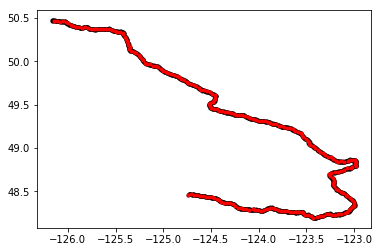

In [13]:
plt.plot(thw_lon,thw_lat, 'k.')
plt.plot(thw_lon_sub,thw_lat_sub, 'r.')
#plt.xlim((-123.5,-123.2))
#plt.ylim(48.8,49.2)
print(' number of points in reduced thalweg is: ',len(thw_lon_sub) )
print(' distance between consecutive points is: ',
      np.mean(geo_tools.haversine(thw_lon_sub[:-1],thw_lat_sub[:-1],
                                thw_lon_sub[1:],thw_lat_sub[1:])), 'km')

In [14]:
thwZ=10.0 # depth interval in thalweg mesh # 5 is too small for model grid
thwzs=np.arange(thwZ/2.0,440.0,thwZ)
# set up 2d mesh:
thmlon=np.tile(thw_lon_sub,(len(thwzs),1))
thmlat=np.tile(thw_lat_sub,(len(thwzs),1))
thmz=np.tile(np.reshape(thwzs,(-1,1)),(1,len(thw_lon_sub)))
thmbot=np.tile(thw_bot_sub,(len(thwzs),1))
thm_isoc=(thmz<thmbot)
print(np.sum(thm_isoc), 'ocean points in thalweg mesh')

5800 ocean points in thalweg mesh


#### 4. Plot points in 3d to get an idea of what we are working with

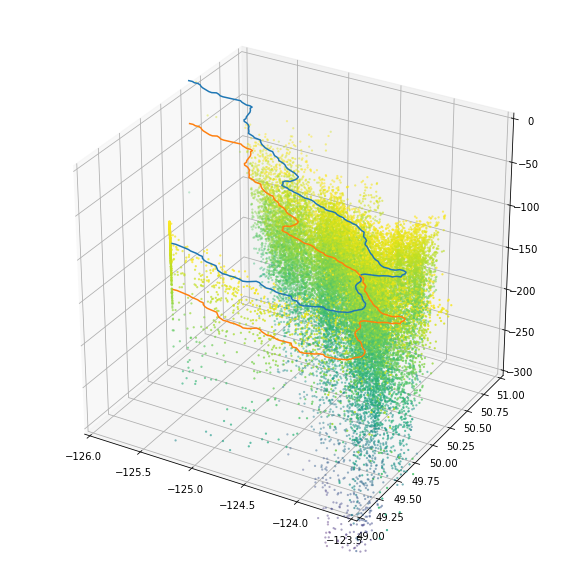

In [15]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,1],points[:,2],points[:,3],c=points[:,3],s=5,lw=0.0)
ax.plot(thw_lon_sub,thw_lat_sub,np.zeros(len(thw_lon_sub)))
ax.plot(thw_lon_sub,thw_lat_sub,-50*np.ones(len(thw_lon_sub)))
#ax.plot(thw_lon10,thw_lat10,-1*np.array(thw_bot10))
ax.view_init(30, -60)
ax.set_xlim([-126,-123.5])
ax.set_ylim([49,51])
ax.set_zlim(-300,0);

#### 5. Define functions that will estimate concentration along thalweg mesh

In [16]:
# gaussian functions for weighting data according to distance from target point
def gweight(dist,dz,sigx,sigz):
    # if len(dist)>1 and len(sig)=1, repeate sig for length of dist
    if isinstance(dist,list): # handle list input
        dist=np.array(dist)
        dz=np.array(dz)
    if isinstance(dist,np.ndarray): # handle list/vector input
        sigx=sigx*np.ones(dist.shape)
        sigz=sigz*np.ones(dist.shape)
    return np.exp(-(dist**2/(2*sigx**2)+dz**2/(2*sigz**2)))

In [17]:
# function to estimate weighted values at a single point in the thalweg mesh
# calculate weighted N by inputing coords of points each with value of 1
# calculate weighted V by inputing coords of model water points with volumes 
# of water at each point
# concentration = weighted N / weighted V

def weighted(reflon, reflat, refz, datalon, datalat, dataz, dataval, sigx, sigz):
    
    distx=geo_tools.haversine(datalon,datalat,
                              reflon*np.ones(len(datalon)),reflat*np.ones(len(datalon)))
    distz=dataz-refz
    
    ind = np.array((distx**2<9*sigx**2)&(distz**2<9*sigz**2)) # select points within 3 sig of reference point

    weights = gweight(distx[ind],distz[ind],sigx,sigz)
    
    return np.sum(weights)

In [18]:
# function to calculate concentration estimates along entire thalweg mesh
def trajConcThw(thmlon,thmlat,thmz,thm_isoc,points,
                modlon_oc,modlat_oc,modz_oc,modV_oc,sigx,sigz):
    thmC=np.nan*np.ones(thmlon.shape)
    thmlon=thmlon[thm_isoc]
    thmlat=thmlat[thm_isoc]
    thmz=thmz[thm_isoc]
    thmC0=np.nan*np.ones(thmlon.shape)
    #thmN0=np.nan*np.ones(thmlon.shape)
    thmV0=np.nan*np.ones(thmlon.shape)
    for ii in range(0,len(thmlon)):
        reflon=thmlon[ii]; reflat=thmlat[ii]; refz=thmz[ii]
        wN=weighted(reflon, reflat, refz, points[:,1], points[:,2], -1.0*points[:,3],
                    np.ones(np.size(points[:,1])), sigx, sigz)
        wV=weighted(reflon, reflat, refz, modlon_oc, modlat_oc, modz_oc, 
                    modV_oc, sigx, sigz)
        # if always using the same thalweg grid (eg every 10th thalweg point and vertical resoluation 10 m) and 
        # the same sigx and sigz, wV could be saved and reloaded to save on calculation time
        thmC0[ii]=wN/wV
        #thmN0[ii]=wN
        thmV0[ii]=wV
    #remove measurements that are artificially large due to small sample volume:
    mV=np.median(thmV0)
    #mN=np.median(thmN0)
    iii=thmV0<0.5*mV
    thmC0[iii]=np.nan
    thmC[thm_isoc]=thmC0
    return thmC

In [19]:
# choose sigx and sigz to be similar to grid: takes less than 20min

t1 = dt.datetime.now()

print (t1)

sigx=3 #km
sigz=12 #m 5 is too small
C=trajConcThw(thmlon,thmlat,thmz,thm_isoc,points,
                modlon_oc,modlat_oc,modz_oc,modV_oc,sigx,sigz)

t2 = dt.datetime.now()
print(t2)

2017-05-29 11:56:44.714273
2017-05-29 12:17:52.366376


#6 Plot

2017-05-29 12:17:52.372725 2017-05-29 12:17:52.440655


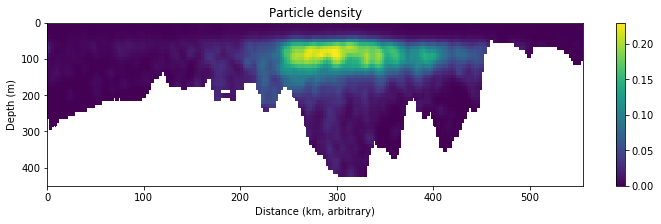

In [20]:
t1 = dt.datetime.now()

fig,ax=plt.subplots(1,1,figsize=(12,3))
pmesh=ax.pcolormesh(geo_tools.distance_along_curve(thmlon[0,:],thmlat[0,:]),thmz[:,0],np.ma.masked_where(np.isnan(C),C))
ax.set_ylim(450,0)
ax.set_xlabel('Distance (km, arbitrary)')
ax.set_ylabel('Depth (m)')
fig.colorbar(pmesh)
ax.set_title('Particle density')

t2 = dt.datetime.now()
print (t1, t2)

In [21]:
deptht[-5:]-deptht[-6:-1]

array([ 26.91597237,  26.92436207,  26.92867168,  26.93088488,  26.93202133])

7. Save

In [22]:
fig.savefig("/ocean/gsgarbi/thalweg/2016_allmonths_{}days".format(nday))